# The weighted generalized mean model of concurrency with gradient descent
The goal of this workbook is to analyze the performance of the gradient descent algorithm in training the generalized mean model.

In [ ]:
%matplotlib inline

In [2]:
from collections import defaultdict
import theano
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from theano import pp
from theano import tensor as T
from theano import function
from theano.ifelse import ifelse
import numpy as np

# An exhaustive study of the errors based on synthetic data
### The weighted generalized mean model

$$
M(\mathbf{x}, \mathbf{w}, p) =  
 \left\{
  \begin{array}{cl}
	\left(\sum_{i=1}^n w_i x_i^p \right)^{\frac{1}{p}}
 	& \texttt{if } p \neq 0 \\
 	\prod_{i=1}^n x_i^{w_i}
 	& \texttt{if } p=0 \\
  \end{array}
 \right.
$$

$$
RT(\mathbf{x}, \mathbf{w}, p, \mu,\sigma) = M(\mathbf{x}, \mathbf{w}, p)  + \exp({\mathcal{N}(\mu,\,\sigma^{2})\,})
$$

$$
\mathbf{x} = \exp({\mathcal{N}(...,\,...)\,})
$$


## Synthetize data with the weighted generalized mean

In [3]:
class WeightedPNormSample(object):
    
    def __init__(self, locX, scaleX, w, p, mu, sigma, training_set_size, validation_set_size, test_set_size):
        """ @param locX: location parameters of log-norm distribution of child transactions
            @param scaleX: scale parameters of log-norm distribution of child transactions
            @param w: weigth parameters of child transactions
            @param p: 
            @param mu: locataion param of log-norm additive noise
            @param sigma: scale param of log-norm additive noise
        """
        self.locX, self.scaleX, self.real_w, self.real_p, self.real_mu, self.real_sigma, = \
             locX,      scaleX,           w,           p,           mu,          sigma, 
        self.training_set_size, self.validation_set_size, self.test_set_size = \
             training_set_size,      validation_set_size,      test_set_size
            
        self.numChildren = len(locX)    
        assert self.locX.shape == (self.numChildren,)
        assert self.scaleX.shape == (self.numChildren,)
        assert self.real_w.shape == (self.numChildren,)
        print "Generating {} training, {} validation and {} test samples using the following parameters:" \
            .format(training_set_size, validation_set_size, test_set_size)
        print "locX = {}        scaleX = {}".format(self.locX, self.scaleX)
        print "w = {},        p = {},        mu = {},        sigma = {}"\
                .format(self.real_w, self.real_p, self.real_mu, self.real_sigma)
        self.train_X_samples     , self.train_RT_samples      = self._sample(training_set_size  ,) 
        self.validation_X_samples, self.validation_RT_samples = self._sample(validation_set_size,)  
        self.test_X_samples      , self.test_RT_samples       = self._sample(test_set_size      ,)

    def _sample(self, N, ):
        """ @param N: number of samples to generate
        """
        X_samples = np.stack((np.exp(np.random.normal(self.locX[child], 
                                                           self.scaleX[child], N)) 
                                   for child in range(self.numChildren)), axis=1)
        M = np.power(np.dot(np.power(X_samples, self.real_p), self.real_w), 1.0/self.real_p)
        RT_samples = M + np.exp(np.random.normal(self.real_mu, self.real_sigma, len(M)))
        return X_samples, RT_samples
  

## Gradient descent algorithm to fit the model

In [29]:
class WeightedPNormGradDesc(object):
    
    num_children = 3
    # model parameter: weights of child transactions
    w = theano.shared(np.ones(num_children) / num_children, 'w')     

    # model parameter: power of child resp times
    p = theano.shared(1.0, 'p')

    # # model param: 
    # mu = theano.shared(0.0, 'mu')        # mean of normal distrib
    # sigma = theano.shared(1.0, 'sigma')  # stddev of normal
    # for now we use 
    m = theano.shared(0.0+(1**2)/2, 'm')          # exp(mu + sigma^2 /2) 

    # every row (selected by 0th coord) is an observation, 
    # fields in a row (1st coord) are child trx resp time in the observation
    X = T.dmatrix('X')  

    # parent resp time, each observation on a separate row
    y = T.dvector('y')

    step_size = T.dscalar('step_size')

    # The expected response time from the model we use:
    XP = T.pow(X, p)
    XPw = T.dot(XP, w)
    #sXPw = T.sum(XPw, axis=0)
    RT = T.pow(XPw, 1/p) + T.exp(m)

    # residual:
    epsilon = y - RT
    
    # penalty if sum of w is not one ...
    #regularization_1 = T.pow((w - 1.0/num_children), 2).sum()*1e-1
    # ... and if negative
    regularization_2 = T.exp((-w-.05)*100).sum() + T.exp((w-1.1)*100).sum() + T.exp(-p*100) + T.exp((p-10)*100)
    
    # Mean squared error
    MSE = 0.5 * T.pow(epsilon, 2).mean() 
    
    # the cost function
    E = MSE + regularization_2

    # the gradient:
    gEw, gEp, gEm = T.grad(E, [w, p, m])
    
    # Here we twist the gradient descent algorithm by normalizing the gradient 
    # along the dimensions related to **w**. We also adjust **w** to be positive.
    gEwL = T.sqrt(T.dot(gEw, gEw))
    w0 = w - step_size * gEw / gEwL
    w0min = T.min(w0)
    w1 = ifelse(T.lt(w0min, 0), w0 - w0min, w0)
    #w2 = w1 / w1.sum()    
    
    training_result_variables = ('XPw', 'RT', 'epsilon', 'regularization_2', 'MSE', 'E',  
                                 'gEw', 'gEp', 'gEm', 'w0', 'w1', 'w', 'p', 'm' )
    train = staticmethod(theano.function(
              inputs=[X, y, step_size],
              outputs=[XPw, RT, epsilon, regularization_2, MSE, E, gEw, gEp, gEm, w0, w1, w, p, m],
              updates=((w, w1), (p, p - step_size * gEp), (m, m - step_size * gEm))
    ))
    prediction_result_variables = 'RT', 'epsilon', 'MSE'
    predict = staticmethod(theano.function(inputs=[X, y], outputs=[RT, epsilon, MSE]))

    def __init__(self, w_init, p_init, m_init, step_size_, training_steps, data):
        self.w_init, self.p_init, self.m_init, self.step_size_, self.training_steps,  = \
             w_init,      p_init,      m_init,      step_size_,      training_steps, 

        print "Training the model using the following parameters:\nstep_size = {},\ttraining_steps = {}" \
            .format(step_size_, training_steps)
            
        self.w.set_value(self.w_init)     
        self.p.set_value(self.p_init) 
        self.m.set_value(self.m_init)  # mu + sigma^2 /2

        # result = ([None]*11)
        for i in range(self.training_steps):
            result = WeightedPNormGradDesc.train(data.train_X_samples, data.train_RT_samples, self.step_size_)

        self.training_results = dict(zip(self.training_result_variables, result))
        print "MSE = {}".format(self.training_results['MSE'])

    def __call__(self, data):
        prediction_result = self.predict(data.test_X_samples, data.test_RT_samples)
        return dict(zip(self.prediction_result_variables, prediction_result))
        
        
    @classmethod
    def evaluate_init(cls, step_size, training_steps, data, N):
        """ Determine how the starting point of the iteration impacts the end-result.
        """
        results = defaultdict(list)
        for i in range(N):
            w_init = np.random.uniform(0, 1, cls.num_children)
            p_init = np.random.uniform(0.4, 4)
            m_init = np.random.uniform(-5, 5)
            wpn = WeightedPNormGradDesc(w_init, p_init, m_init, step_size, training_steps, data)
            results['w'].append(w)
            results['p'].append(p)
            results['mu'].append(m)  # (m, data.real_mu + data.real_sigma^2 /2)

            #RT_predictions, epsilon = predict(data.validation_X_samples, data.validation_RT_samples)
        pass  # plot RT_samples vs. RT_predictions
        pass  # plot the distribution of epsilon    
        return results
    
    @classmethod
    def evaluate_real(cls, step_size, training_steps, N):
        """ Determine how the real values of the model parameters impact the error.
        """
        w_init = np.ones(cls.num_children) / cls.num_children
        p_init = 1.0
        m_init = 0.0
        results = list() #results = defaultdict(list)
        for i in range(N):
            print "i = {}".format(i)
            locX = np.random.uniform(-1, 1, cls.num_children)
            scaleX = np.random.uniform(0, 2, cls.num_children)
            real_w = np.random.uniform(0, 1, cls.num_children)
            real_p = np.random.uniform(0.4, 4)
            real_mu = np.random.uniform(-1, 1)
            real_sigma = 0.0
            data = WeightedPNormSample(locX, scaleX, real_w, real_p, real_mu, real_sigma, 
                                       training_set_size=5000, 
                                       validation_set_size=0, 
                                       test_set_size=5000)
            wpn = WeightedPNormGradDesc(w_init, p_init, m_init, step_size, training_steps, data)
            results.append( (data, wpn.training_results, wpn(data)))
        return results    

## Evaluate the fitting algorithm
### Generate data points for the evaluation
For each data point:

- a random value for the parameters locX, scaleX, real_w, real_p, real_mu, real_sigma is chosen
- a training and a test data sets are generated
- the model is fit to the training data
- a prediction is generated on the test data using the fit model

In [36]:
results = WeightedPNormGradDesc.evaluate_real(step_size=0.01, training_steps = 2000, N=50)

i = 0
Generating 5000 training, 0 validation and 5000 test samples using the following parameters:
locX = [ 0.02033041  0.65183954  0.9781729 ]        scaleX = [ 1.8473737   0.7714647   0.44479127]
w = [ 0.15208425  0.13671727  0.54575383],        p = 1.70845730622,        mu = -0.648981643469,        sigma = 0.0
Training the model using the following parameters:
step_size = 0.01,	training_steps = 2000
MSE = 0.309309333657
i = 1
Generating 5000 training, 0 validation and 5000 test samples using the following parameters:
locX = [ 0.36816136 -0.02260542  0.17810505]        scaleX = [ 1.01194086  0.45786117  0.94313109]
w = [ 0.07044933  0.90543597  0.29758752],        p = 3.7099599605,        mu = 0.218488149546,        sigma = 0.0
Training the model using the following parameters:
step_size = 0.01,	training_steps = 2000
MSE = 0.0101752960474
i = 2
Generating 5000 training, 0 validation and 5000 test samples using the following parameters:
locX = [-0.82044237 -0.99145015  0.9177698 ]    

### Examine the mean squared error on the training and test data sets

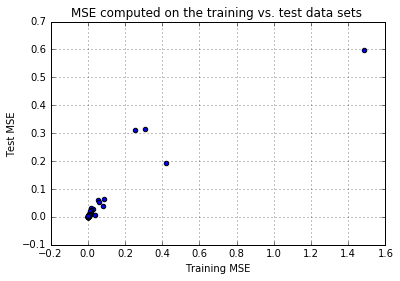

In [45]:
def plot_MSE_vs_MSE(results):
    series = defaultdict(list)
    for data, wpn_results, prediction_results in results:
        series['MSE'].append((wpn_results['MSE'], prediction_results['MSE'], ))
    
    for parameter, data in series.items():
        plt.title('MSE computed on the training vs. test data sets ')
        plt.grid()
        plt.scatter(*zip(*data))
        plt.xlabel('Training MSE')
        plt.ylabel('Test MSE')
        plt.show()
plot_MSE_vs_MSE(results)

For most of the data points both the training and the test MSE are small; for cc. 1 out of 10 data points both are high.

**On the data points with high test MSE the training MSE was even higher!** Either the gradient descent did not converge or it converged to a wrong local minimum.

In one of the cases the test MSE was NaN.
### Examine the dependence of the MSE on the actual model parameters
Is there a particular domain of some of the parameters that cause the high MSE?

In [39]:
def plot_MSE_vs_prediction(results):
    series = defaultdict(list)
    for data, wpn_results, prediction_results in results:
        series['w_0'].append((data.real_w[0], prediction_results['MSE'], ))
        series['w_1'].append((data.real_w[1], prediction_results['MSE'], ))
        series['w_2'].append((data.real_w[2], prediction_results['MSE'], ))
        series['p'  ].append((data.real_p   , prediction_results['MSE'], ))
        series['m'  ].append((data.real_mu + data.real_sigma**2.0/2, prediction_results['MSE'], ))
    
    for parameter, data in series.items():
        plt.title('Dependence of the MSE on the actual value of {}'.format(parameter))
        plt.grid()
        plt.scatter(*zip(*data))
        plt.xlabel(parameter)
        plt.ylabel('MSE')
        plt.show()

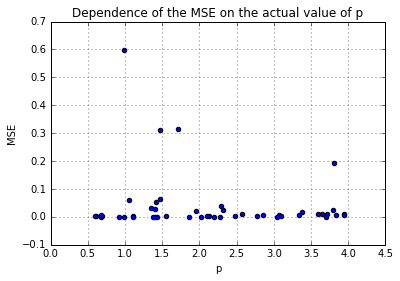

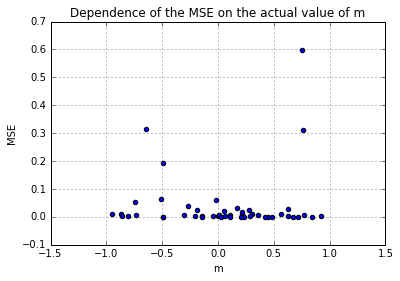

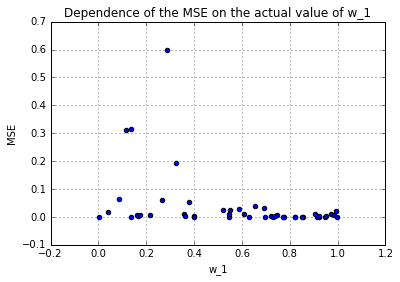

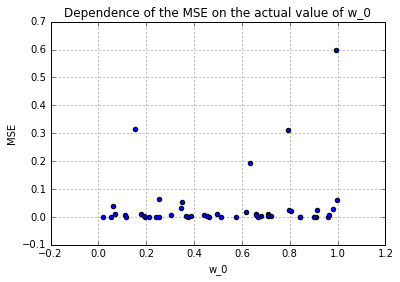

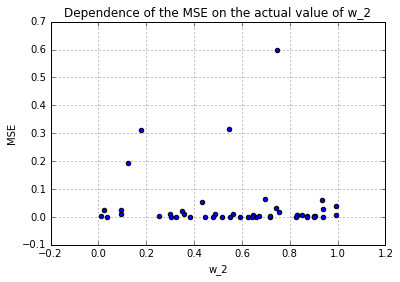

In [40]:
plot_MSE_vs_prediction(results)

There seems to be no particular domain of any of the parameters that cause the high MSE.

### Examine the actual vs. the recovered model parameters

In [37]:
def plot_actual_vs_prediction(results):
    series = defaultdict(list)
    for data, training_results, prediction_results in results:
        series['w_0'].append((training_results['w'][0], data.real_w[0], ))
        series['w_1'].append((training_results['w'][1], data.real_w[1], ))
        series['w_2'].append((training_results['w'][2], data.real_w[2], ))
        series['p'].append((training_results['p'], data.real_p, ))
        series['m'].append((training_results['m'], data.real_mu + data.real_sigma**2.0/2, ))
    
    for title, data in series.items():
        plt.title(title)
        plt.grid()
        plt.scatter(*zip(*data))
        plt.xlabel('prediction')
        plt.ylabel('actual')
        plt.show()

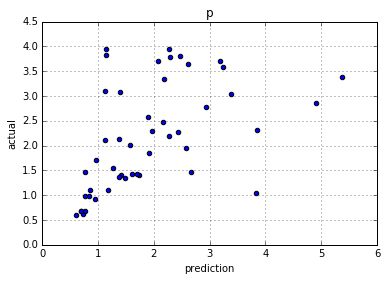

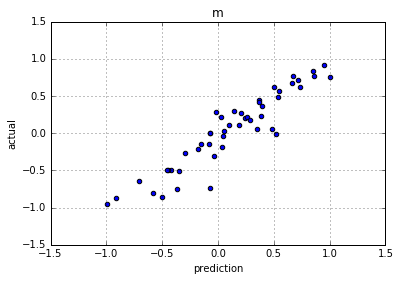

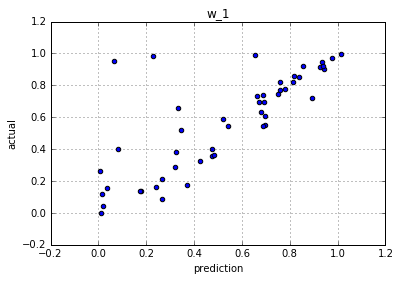

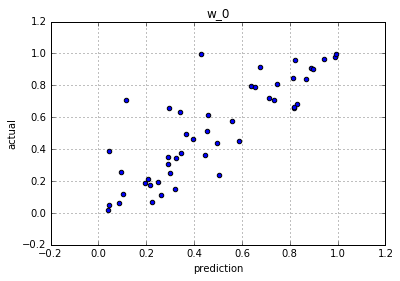

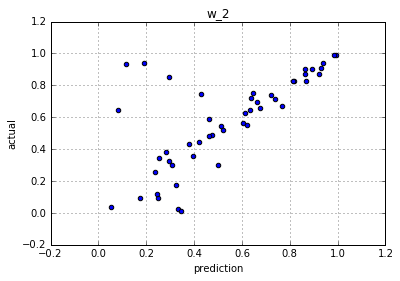

In [38]:
plot_actual_vs_prediction(results)

The most accurately recovered parameter is $m$, the least accurate is $p$

# Summary
In 90% of the data points the MSE was relatively low. The high MSE data points show no obvious relation to particular parameter values.

My assumption is that the high MSE points did not converge because of an inappropriate step size. Next step is to try Raphson's method, where the step size and number of iterations is less of an importance.